<a href="https://colab.research.google.com/github/thomasshin/NLP_Study/blob/main/Pytorch_Practices/Pytorch_Computer_Vision_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch as nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

print(torch.__version__)
print(torchvision.__version__)

2.0.1+cu118
0.15.2+cu118


In [ ]:
train_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor(),
    target_transform = None
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)

100%|██████████| 26421880/26421880 [00:00<00:00, 114842491.99it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 3057569.71it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 60592807.35it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6118525.64it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
image, label = train_data[0]
image.shape

torch.Size([1, 28, 28])

[color_channels=1, height=28, width=28]

If color_channels=3, the image comes in pixel values for red, green and blue (this is also known a the RGB color model).

The order of our current tensor is often referred to as CHW (Color Channels, Height, Width).

There's debate on whether images should be represented as CHW (color channels first) or HWC (color channels last).

You'll also see NCHW and NHWC formats where N stands for number of images. For example if you have a batch_size=32, your tensor shape may be [32, 1, 28, 28]. We'll cover batch sizes later.

PyTorch generally accepts NCHW (channels first) as the default for many operators.

However, PyTorch also explains that NHWC (channels last) performs better and is considered best practice.

For now, since our dataset and models are relatively small, this won't make too much of a difference.

But keep it in mind for when you're working on larger image datasets and using convolutional neural networks (we'll see these later).

Let's check out more shapes of our data.

In [ ]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [ ]:
class_names = train_data.classes

Because we're working with 10 different classes, it means our problem is multi-class classification.

In [ ]:
image.shape, image.squeeze().shape

(torch.Size([1, 28, 28]), torch.Size([28, 28]))

Text(0.5, 1.0, '9')

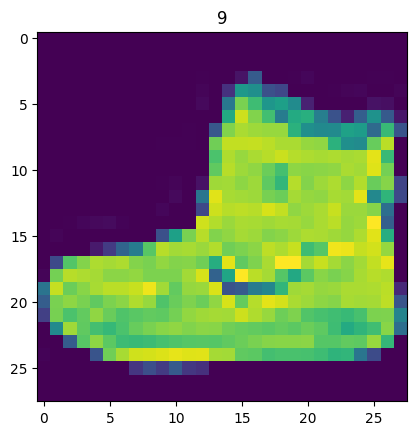

In [ ]:
image,label = train_data[0]
plt.imshow(image.squeeze())
plt.title(label)

Text(0.5, 1.0, 'Ankle boot')

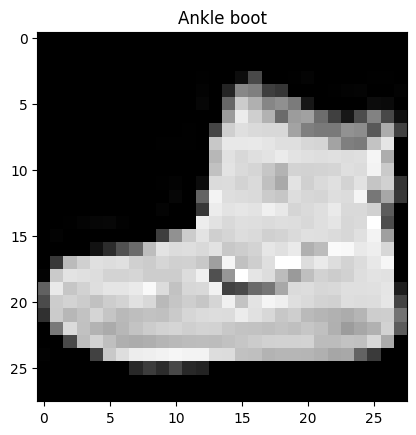

In [ ]:
plt.imshow(image.squeeze(), cmap = "gray")
plt.title(class_names[label])

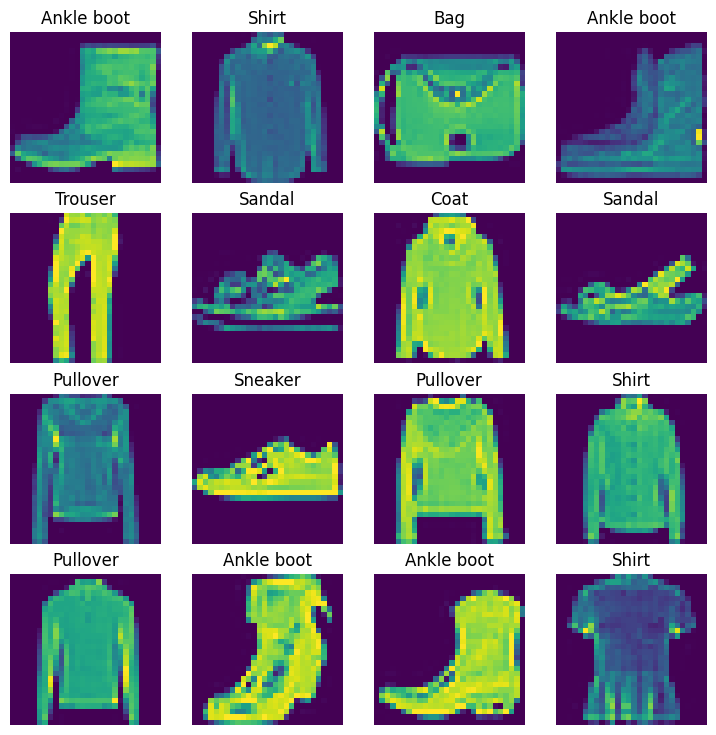

In [ ]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
row, col = 4, 4

for i in range(1, row * col + 1):
  rand_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[rand_idx]
  plt.subplot(4,4,i)
  plt.imshow(img.squeeze())
  plt.title(class_names[label])
  plt.axis(False)

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,
                              batch_size = BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

print(f"DataLoaders : {train_dataloader}, {test_dataloader}")
print(f"length of train_dataLoaders : {len(train_dataloader)}, batch size : {BATCH_SIZE}")
print(f"length of test_dataLoaders : {len(test_dataloader)}, batch size : {BATCH_SIZE}")

DataLoaders : <torch.utils.data.dataloader.DataLoader object at 0x7c0063428d00>, <torch.utils.data.dataloader.DataLoader object at 0x7c0063429570>
length of train_dataLoaders : 1875, batch size : 32
length of test_dataLoaders : 313, batch size : 32


In [ ]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
print(train_features_batch.shape, train_labels_batch.shape)

torch.Size([32, 1, 28, 28]) torch.Size([32])


Text(0.5, 1.0, 'Shirt')

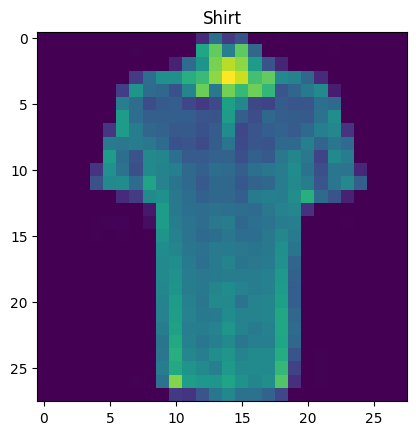

In [ ]:
torch.manual_seed(42)
ran_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[ran_idx], train_labels_batch[ran_idx]
label = class_names[ran_idx]
plt.imshow(img.squeeze())
plt.title(label)

#Build a baseline model

A baseline model is one of the simplest models you can imagine.

Because we're working with image data, we're going to use a different layer to start things off.

And that's the nn.Flatten() layer.

In [ ]:
import torch
import torch as nn

x = train_features_batch[0]
flat = nn.flatten(x, start_dim=1)
print(x.shape, flat.shape)

torch.Size([1, 28, 28]) torch.Size([1, 784])


In [ ]:
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {flat.shape} -> [color_channels, height*width]")

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


The nn.Flatten() layer took our shape from [color_channels, height, width] to [color_channels, height*width].

Why do this?

Because we've now turned our pixel data from height and width dimensions into one long feature vector.

And nn.Linear() layers like their inputs to be in the form of feature vectors.

Let's create our first model using nn.Flatten() as the first layer.

In [ ]:
import torch
from torch import nn

class cvmodel(nn.Module):
  def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_shape)
    )
  def forward(self, x):
    return self.layer_stack(x)

input_shape=784 - this is how many features you've got going in the model, in our case, it's one for every pixel in the target image (28 pixels high by 28 pixels wide = 784 features).

hidden_units=10 - number of units/neurons in the hidden layer(s), this number could be whatever you want but to keep the model small we'll start with 10.

output_shape=len(class_names) - since we're working with a multi-class classification problem, we need an output neuron per class in our dataset.

In [ ]:
torch.manual_seed(42)

model_0 = cvmodel(input_shape=784,
                  hidden_units=10,
                  output_shape=len(class_names))

model_0.to('cpu')

cvmodel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [ ]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

time our model

In [ ]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

#creating training / testing loop for batches of data


1. Loop through epochs.

2. Loop through training batches, perform training steps, calculate the train loss per batch.

3. Loop through testing batches, perform testing steps, calculate the test loss per batch.

4. Print out what's happening.

5. Time it all (for fun).

In [ ]:
from tqdm.auto import tqdm

In [ ]:
torch.manual_seed(42)
epochs = 5
train_time_start_on_cpu = timer()

for epoch in tqdm(range(1, epochs+1)):
  print(f"Epoch: {epoch}\n--------")
  train_loss = 0
  #training
  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()
    batch_y_pred = model_0(X)
    batch_y_label = torch.argmax(torch.relu(batch_y_pred), dim=1)
    batch_train_loss = loss_fn(batch_y_pred, y)
    train_loss += batch_train_loss
    optimizer.zero_grad()
    batch_train_loss.backward()
    optimizer.step()
    if batch % 400 == 0:
      print(f"Looked at {batch * 32} / {len(train_dataloader.dataset)} samples")
  train_loss /= len(train_dataloader)

  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for batch, (X, y) in enumerate(test_dataloader):
      batch_test_pred = model_0(X)
      batch_test_label = torch.argmax(torch.relu(batch_test_pred), dim=1)
      batch_test_loss = loss_fn(batch_test_pred, y)
      batch_test_acc = accuracy_fn(y, batch_test_pred.argmax(dim=1))
      test_loss += batch_test_loss
      test_acc += batch_test_acc
    test_loss /= len(train_dataloader)
    test_acc /= len(train_dataloader)
  print(f"Train_loss : {train_loss} | Test_loss : {test_loss} | Test_Accuracy : {test_acc}\n")

#time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_0.parameters()).device))

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
--------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples
Train_loss : 0.5903892517089844 | Test_loss : 0.08505839109420776 | Test_Accuracy : 13.695

Epoch: 2
--------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples
Train_loss : 0.4763319790363312 | Test_loss : 0.08010964840650558 | Test_Accuracy : 13.888333333333334

Epoch: 3
--------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples
Train_loss : 0.4550333619117737 | Test_loss : 0.07956692576408386 | Test_Accuracy : 13.926666666666666

Epoch: 4
--------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples
Trai

#Make prediction and get model_0 result

let's create a function that takes in a trained model, a DataLoader, a loss function and an accuracy function.

The function will use the model to make predictions on the data in the DataLoader and then we can evaluate those predictions using the loss function and accuracy function.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
torch.manual_seed(42)

def eval_model(model:torch.nn.Module,
               data_loader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               accuracy_fn):

    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """

    loss, acc = 0, 0
    model.to(device)
    model.eval()
    with torch.inference_mode():
      for X, y in data_loader:
        X, y= X.to(device), y.to(device)
        y_pred = model(X)
        loss += loss_fn(y_pred, y)
        acc += accuracy_fn(y, torch.argmax(torch.sigmoid(y_pred), dim=1))
      loss /= len(data_loader)
      acc /= len(data_loader)

    return {"model name" : model.__class__.__name__, #only works when the model was created with class
            "model_loss" : loss.item(),
            "model_accuracy" : acc}

print(eval_model(model_0, test_dataloader, loss_fn, accuracy_fn))

{'model name': 'cvmodel', 'model_loss': 0.4686937928199768, 'model_accuracy': 83.28674121405751}


In [ ]:
#device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#Building a model with non-linearity

In [ ]:
class cvmodel2(nn.Module):
  def __init__(self, input: int, hidden: int, output: int):
    super().__init__()
    self.layer_stack= nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input, out_features=hidden),
        nn.ReLU(),
        nn.Linear(in_features=hidden, out_features=hidden),
        nn.ReLU(),
        nn.Linear(in_features=hidden, out_features=output),
        nn.ReLU()
    )
  def forward(self, x):
    return self.layer_stack(x)

In [ ]:
model_1 = cvmodel2(input=28*28, hidden=10, output=len(class_names)).to(device)
model_1

cvmodel2(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
    (5): Linear(in_features=10, out_features=10, bias=True)
    (6): ReLU()
  )
)

In [ ]:
next(model_1.parameters()).device

device(type='cuda', index=0)

In [ ]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [ ]:
i = 1
for (X, y) in enumerate(test_dataloader):
  print("feature", X)
  print("label", y)
  print("--------------------------------------------------")
  i -= 1

Streaming output truncated to the last 5000 lines.
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000]]]]), tensor([5, 4, 1, 5, 7, 7, 8, 2, 8, 3, 7, 4, 6, 2, 9, 9, 0, 0, 7, 3, 1, 0, 8, 2,
        4, 4, 6, 7, 1, 8, 6, 0])]
--------------------------------------------------
feature 227
label [tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
 

#Functionalizing training and testing loops

In [ ]:
def train_step(model:torch.nn.Module,
               data_loader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               accuracy_fn,
               device:torch.device=device):
  train_loss, train_acc = 0, 0
  model.to(device)
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    train_pred = model(X)
    loss = loss_fn(train_pred, y)
    train_acc += accuracy_fn(y, torch.argmax(torch.sigmoid(train_pred), dim=1))
    train_loss += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"train loss : {train_loss} | train accuracy : {train_acc}")

def test_step(model:torch.nn.Module,
              data_loader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              accuracy_fn,
              device:torch.device=device):
  test_loss, test_acc = 0, 0
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for X, y in (data_loader):
      X, y = X.to(device), y.to(device)
      test_pred = model(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y, torch.argmax(torch.sigmoid(test_pred), dim=1))
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
  print(f"test loss : {test_loss} | test accuracy : {test_acc}")

Training and Testing loops using functions

In [ ]:
torch.manual_seed(42)
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3

for epoch in range(1, epochs+1):
  print(f"-------------epoch : {epoch}-------------")
  train_step(model = model_1,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy_fn = accuracy_fn,
            )
  test_step(model = model_1,
            data_loader = test_dataloader,
            loss_fn = loss_fn,
            accuracy_fn = accuracy_fn)

train_time_end_on_gpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

-------------epoch : 1-------------
train loss : 0.9259966015815735 | train accuracy : 65.84666666666666
test loss : 0.5814549326896667 | test accuracy : 79.36301916932908
-------------epoch : 2-------------
train loss : 0.5062161087989807 | train accuracy : 81.99666666666667
test loss : 0.5584304332733154 | test accuracy : 79.71246006389777
-------------epoch : 3-------------
train loss : 0.4604541063308716 | train accuracy : 83.42666666666666
test loss : 0.5389129519462585 | test accuracy : 81.6094249201278
Train time on cuda: 29.369 seconds


In [ ]:
print(eval_model(model_0,
                 test_dataloader,
                 loss_fn,
                 accuracy_fn))

{'model name': 'cvmodel', 'model_loss': 0.4686937928199768, 'model_accuracy': 83.28674121405751}


#Building a Convolutional Neural Network (CNN)

The CNN model we're going to be using is known as TinyVGG from the CNN Explainer website.

https://poloclub.github.io/cnn-explainer/

Input layer -> [Convolutional layer -> activation layer -> pooling layer] -> Output layer

Where the contents of [Convolutional layer -> activation layer -> pooling layer] can be upscaled and repeated multiple times, depending on requirements.

Problem type : Structured data (Excel spreadsheets, row and column data)

Model to use (generally) : Gradient boosted models, Random Forests, XGBoost

Code example : sklearn.ensemble, XGBoost library

Unstructured data : (images, audio, language)

Model to use (generally) : Convolutional Neural Networks, Transformers

Code example : torchvision.models, HuggingFace Transformers

To do so, we'll leverage the nn.Conv2d() and nn.MaxPool2d() layers from torch.nn.

In [ ]:
class model_conv(nn.Module):
  """
  Model architecture copying TinyVGG from:
  https://poloclub.github.io/cnn-explainer/
  """
  def __init__(self, input:int, hidden:int, output:int):
    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input,
                  out_channels=hidden,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden,
                  out_channels=hidden,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                      stride=2)
    )
    self.block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden,
                  out_channels=hidden,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden,
                  out_channels=hidden,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                      stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden*7*7,
                  out_features=output)
    )

  def forward(self, x:torch.Tensor):
    x = self.block_1(x)
    x = self.block_2(x)
    x = self.classifier(x)
    return x

torch.manual_seed(42)
model_3 = model_conv(input=1, hidden=10, output=len(class_names)).to(device)
model_3

model_conv(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

#Stepping through nn.Conv2d()

- nn.Conv2d() : convolutional layer
- nn.MaxPool2d() : max pooling layer

To test the layers out, let's create some toy data just like the data used on CNN Explainer.

In [ ]:
torch.manual_seed(42)

images = torch.randn(size=(32,3,64,64)) #[batch_size, color channel, height, width]
test_image = images[0]
print(f"image batch shape : {images.shape} -> [batch_size, color_channels, height, width]")
print(f"single image shape : {test_image.shape} -> [color_channels, height, width]")
print(f"single image pixel values : \n{test_image}")

image batch shape : torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
single image shape : torch.Size([3, 64, 64]) -> [color_channels, height, width]
single image pixel values : 
tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3

Let's create an example nn.Conv2d() with various parameters:

**in_channels** (int) - Number of channels in the input image.

**out_channels** (int) - Number of channels produced by the convolution.

**kernel_size** (int or tuple) - Size of the convolving kernel/filter.

**stride** (int or tuple, optional) - How big of a step the convolving kernel takes at a time. Default: 1.

**padding** (int, tuple, str) - Padding added to all four sides of input. Default: 0.

In [ ]:
torch.manual_seed(42)

#our first conv layer
conv_layer = nn.Conv2d(
    in_channels=3,
    out_channels=10,
    kernel_size=3,
    stride=1,
    padding=0
)

#pass the image to conv layer
after_conv = conv_layer(test_image)

#original
print(f"original shape : {test_image.shape}")
#after
print(f"shape after passing through CNN: {after_conv.shape}")

original shape : torch.Size([3, 64, 64])
shape after passing through CNN: torch.Size([10, 62, 62])


In [ ]:
#maxpool2d layer
maxpool_layer = nn.MaxPool2d(
    kernel_size=2,
)

after_conv_maxpool = maxpool_layer(after_conv)
print(f"shape after passing through CNN: {after_conv.shape}")
print(f"shape after passing through CNN and maxpool: {after_conv_maxpool.shape}")

shape after passing through CNN: torch.Size([10, 62, 62])
shape after passing through CNN and maxpool: torch.Size([10, 31, 31])


let's work with smaller tensor

In [ ]:
torch.manual_seed(42)
tensor1 = torch.randn([1,1,2,2])
tensor1_max = maxpool_layer(tensor1)
print(f"random tensor :\n{tensor1}")
print(f"shape of random tensor :\n{tensor1.shape}")
print(f"after maxpool :\n{tensor1_max}")
print(f"shape after maxpool :\n{tensor1_max.shape}")

random tensor :
tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
shape of random tensor :
torch.Size([1, 1, 2, 2])
after maxpool :
tensor([[[[0.3367]]]])
shape after maxpool :
torch.Size([1, 1, 1, 1])


loss function and optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

In [ ]:
# Create a convolutional neural network
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

model_4 = FashionMNISTModelV2(input_shape=1, hidden_units=10, output_shape=10)

Training and testing our conv model

In [ ]:
torch.manual_seed(42)
epochs = 3

#time

from timeit import default_timer as timer
train_time_model3_start = timer()

for epoch in tqdm(range(1, epochs+1)):
  print(f"--------------------epoch : {epoch}--------------------")
  train_step(model=model_3,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)

  test_step(model=model_3,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

train_time_model3_end = timer()
total_train_time = print_train_time(start=train_time_model3_start,
                                    end=train_time_model3_end,
                                    device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

--------------------epoch : 1--------------------
train loss : 0.5964305996894836 | train accuracy : 78.30333333333333
test loss : 0.4046366214752197 | test accuracy : 85.52316293929712
--------------------epoch : 2--------------------
train loss : 0.364496111869812 | train accuracy : 86.76
test loss : 0.35378125309944153 | test accuracy : 87.01078274760384
--------------------epoch : 3--------------------
train loss : 0.3246210515499115 | train accuracy : 88.17166666666667
test loss : 0.32406535744667053 | test accuracy : 88.2388178913738
Train time on cuda: 39.821 seconds


In [ ]:
#evaluation

model_conv_result = eval_model(
    model=model_3,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

model_lin_result = eval_model(
    model=model_0,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

model_nonlin_result = eval_model(
    model=model_1,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
print(model_conv_result)
print(model_lin_result)
print(model_nonlin_result)

{'model name': 'model_conv', 'model_loss': 0.32406535744667053, 'model_accuracy': 88.2388178913738}
{'model name': 'cvmodel', 'model_loss': 0.4686937928199768, 'model_accuracy': 83.28674121405751}
{'model name': 'cvmodel2', 'model_loss': 0.5389129519462585, 'model_accuracy': 81.6094249201278}


Display the performance of each model

In [ ]:
import pandas as pd

results = pd.DataFrame([model_lin_result, model_nonlin_result, model_conv_result])
print(results)

   model name  model_loss  model_accuracy
0     cvmodel    0.468694       83.286741
1    cvmodel2    0.538913       81.609425
2  model_conv    0.324065       88.238818


<Axes: ylabel='model name'>

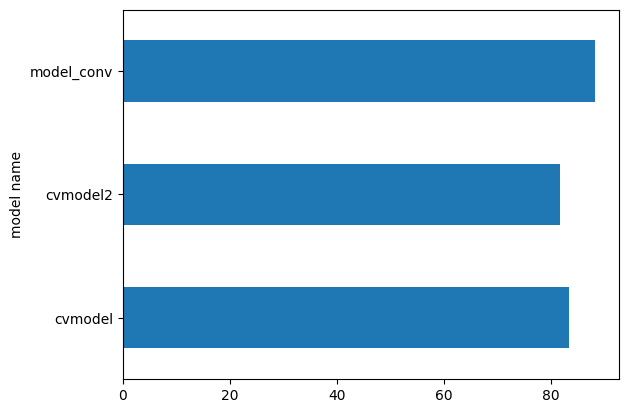

In [ ]:
results.set_index("model name")["model_accuracy"].plot(kind="barh")

#Make and evaluate random predictions with best model

In [ ]:
def make_predictions(model:torch.nn.Module, data:list, device:torch.device=device):
  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0).to(device)
      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
      pred_probs.append(pred_prob.cpu())
    return torch.stack(pred_probs)

In [ ]:
import random
random.seed(42)

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data),k=9):
  test_samples.append(sample)
  test_labels.append(label)

print(f"test sample shape : {test_samples[0].shape}\ntest label : {test_labels[0]}\nclass : {class_names[test_labels[0]]}")

test sample shape : torch.Size([1, 28, 28])
test label : 5
class : Sandal


In [ ]:
pred_probs = make_predictions(model=model_3, data=test_samples)
pred_probs[:2]

tensor([[3.7403e-08, 1.3587e-08, 1.6425e-08, 5.5763e-08, 5.9729e-09, 9.9986e-01,
         7.7467e-08, 2.4192e-05, 2.0198e-05, 9.7130e-05],
        [2.4822e-02, 7.7498e-01, 3.9656e-04, 1.2846e-01, 2.6257e-02, 1.4512e-05,
         4.4803e-02, 8.1948e-05, 1.5999e-04, 2.3193e-05]])

In [ ]:
pred_labels = torch.argmax(pred_probs, dim=1)

In [ ]:
pred_labels, test_labels

(tensor([5, 1, 7, 4, 3, 0, 4, 7, 1]), [5, 1, 7, 4, 3, 0, 4, 7, 1])

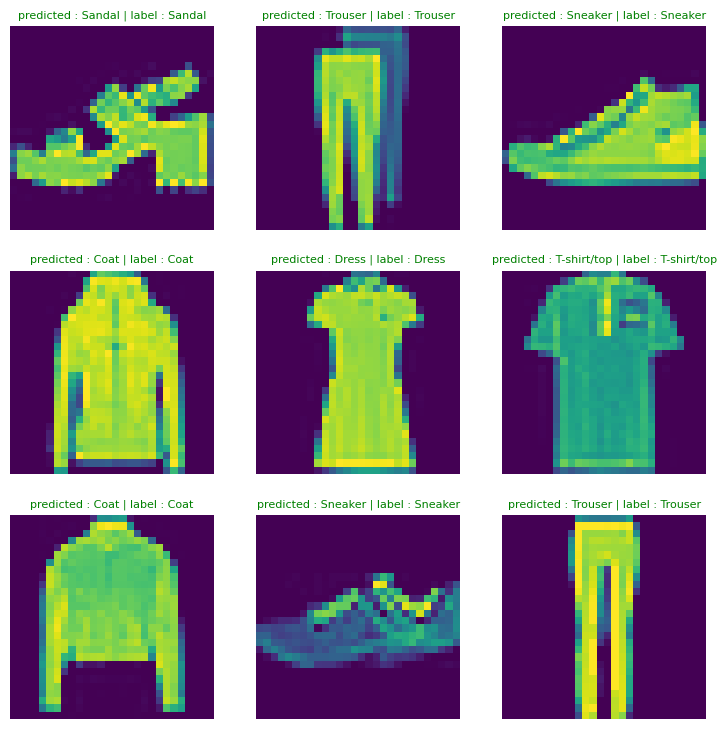

In [ ]:
#plot predictions
plt.figure(figsize=(9,9))
nrows, ncols = 3, 3
# Create a subplot
for idx, val in enumerate(test_samples):
  plt.subplot(3, 3, idx+1)
# Plot the target image
  plt.imshow(val.squeeze())
# Find the prediction label (in text form, e.g. "Sandal")
  pred_la = class_names[pred_labels[idx]]
# Get the truth label (in text form, e.g. "T-shirt")
  test_la = class_names[test_labels[idx]]
# Create the title text of the plot
  title_text = "predicted : {0} | label : {1}".format(pred_la, test_la)
# Check for equality and change title colour accordingly
  if (pred_la == test_la):
    plt.title(title_text, fontsize = 8, c="g")
  else:
    plt.title(title_text, fontsize = 8, c="r")
  plt.axis(False)